In [1]:
from openai import OpenAI
import pandas as pd
import re
import pickle
import numpy as np
import time


#uses api key in .env
client = OpenAI()

In [6]:
df = pd.read_csv('../fewshot_labels/trans16_milan_merged.csv')
#first val is empty
df = df[1:]

#remove the /t from all the text, also get rid of the space before every sentence
df['content'] = df['content'].str.rstrip('\t').str.lstrip(' ')

#only want the content and label
data = df.iloc[:,-2:].reset_index(drop=True)


content = data['content']
labels = data['labels_h']


In [40]:
def format_utterances(utterances_df):

    '''
    utterances_df (dataframe or listof (str)): This should be a pandas dataframe or a list of strings where each element in the df or list is an utterance. Indexing utterances_df like utterances_df[index] should return a string of an utterance

    Returns a string in the form:

    1. first utterance\n
    2. second utterance\n
    3. third utterance\n
    n. nth utterance

    Containing each utterance in utterances_df

    '''

    formatted_utterances = "\n".join([f"{i+1}. {utterance}" for i, utterance in enumerate(utterances_df)])

    return formatted_utterances

    



In [41]:

def extract_data(text, num_utterances):
    '''
    Extracts classifications and explanations from text in the format:

    Classifications:
    [<q>, <s>, <s>, <s>, <s>, <b>, <d>]


    Explanations:
    1. The utterance "What’s taking so long?" is a question because it starts with "What" and ends with a question mark.
    2. The utterance "You keep working." is a statement because it is a complete sentence that expresses a fact or opinion.
    3. The utterance "Eat something if you want." is a statement because it is a complete sentence that expresses a suggestion or possibility.
    4. The utterance "I see you are feeling bored. She is missing the letters. Read." is a statement because it is a sequence of complete sentences that express observations and instructions.
    5. The utterance "There’s a lot accumulated for you." is a statement because it is a complete sentence that expresses a fact or situation.
    6. The utterance "Right here." is a backchannel because it is a short utterance that indicates understanding or acknowledgement.
    7. The utterance "Oh, shit! Didn’t mean to do that." is an incomplete utterance because it is an interrupted utterance that is not complete.

    returns a list of classifications -> [<q>, <s>, <s>, <s>, <s>, <b>, <d>]
    returns a list of explanations -> [explanation 1,explanation 2, ...]


    '''



    # Extract Classifications
    pattern = re.compile(r'\[([^\]]*)\]')

    matches = pattern.findall(text)

    if matches:
        classifications = [value.strip() for value in matches[0].split(',') if value.strip()]


    if len(classifications) != num_utterances:
        classifications = ['Failed to retrieve'] * num_utterances

    # Extract Explanations
    pattern = re.compile(r'\d+\.\s(.+?)(?=\d+\.|\Z)', re.DOTALL)

    # Use findall to extract all matches
    explanations = pattern.findall(text)
    # Strip '\n' characters from each statement
    explanations = [re.sub(r'\s+', ' ', statement) for statement in explanations]

    if len(explanations) != num_utterances:
        explanations = ['Failed to retrieve'] * num_utterances

    #make sure output is all the same format
    s_map = {
        'question': 'q',
        'statement': 's',
        'follow me': 'f',
        'follow-me': 'f',
        'backchannel': 'b',
        'back channel': 'b',
        'back-channel': 'b',
        'incomplete utterance': 'd',
        'incomplete-utterance': 'd', 
    }

    special_characters = ['<', '>', "'", '"']

    classifications = ["".join(char for char in s if char not in special_characters).lower() for s in classifications]

    classifications = [s_map[s] if s in s_map else s for s in classifications]

    return classifications, explanations




In [108]:
text = '''
    
    Classifications:
    [<statement>, <b>, hi's>>]


    Explanations:
    1. The utterance "What’s taking so long?" is a question because it starts with "What" and ends with a question mark.
    2. The utterance "You keep working." is a statement because it is a complete sentence that expresses a fact or opinion.
    3. hii
    
    '''


print(extract_data(text, num_utterances=3))

(['s', 'b', 'his'], ['The utterance "What’s taking so long?" is a question because it starts with "What" and ends with a question mark. ', 'The utterance "You keep working." is a statement because it is a complete sentence that expresses a fact or opinion. ', 'hii '])


In [109]:
def predict(utterances, num_utterances):

    '''
    Utterances (str): Should be a sequence of utterances in the format:

    1. "first utterance"\n
    2. "second utterance"\n
    3. "third utterance"\n
    n. "nth utterance"

    This should be a single string

    Returns listof (str): This will be a list of classifications where each str in the list
    is a dialogue act prection for the corresponding utterance in utterances.

    '''

    user_prompt = utterances


    try:
        response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
        "role": "system",

        "content": "You are a dialogue act classifier that uses its expert knowledge of linguistics and dialogue act theory to predict dialogue act classifications for a sequence of utterances. \n\nUtterances may be classified as one of the five following dialogue acts:\n\nStatement <s>:\nThe <s> tag is the most widely used. Unless an utterance is completely indecipherable or else can be further described by a general tag as being a\ntype of question, backchannel, follow-me, or disruption, then its default status as a statement remains. \n\n\"Follow Me\" <f>:\nThe <f> tag marks utterances made by a speaker who wants to verify that what he is saying is being understood. Utterances marked with the <f> tag explicitly communicate or else implicitly communicate the questions \"do you follow me?\" or \"do you understand?\" In implicitly communicating those questions, a speaker's utterance may be a question, such as \"right?\" or \"okay?\", where a sense of \"do you understand?\" is being conveyed. Questions marked with the \"follow me\" <f> tag often occur in instances in which a speaker is attempting to be instructional or else is offering an explanation. After an instruction or explanation, a speaker may utter a question that is also a \"follow me\" in order to gauge whether what he is saying is understood.\n\nQuestions <q>:\nThe <q> tag is used to denote any form of question that is not a \"follow-me\" <f>. Some examples of questions are: \"How are you?\", \"Did you get that thing?\", \"Who was that?\".\n\nIncomplete Utterance <d>:\nThe <d> tag is used to mark utterances that are abandoned, or incomplete.  Incomplete Utterances can be represented in an utterance through certain symbols. For example, an ellipsis can be used to mark an utterance as interrupted as in the following example: \" No, we already…\". Additionally, the \"[UI]\" tag can be used to indicate an unintelligible utterance as in the example: \"It’s just [UI]\".  Some examples of Incomplete Utterances are: \"Did you...\", \"I want [UI]\", \"There is a...\".\n\nBackchannel <b>:\nThe <b> tag marks utterances that are backchannels. Utterances that function as backchannels are not made by the speaker who has the\nfloor. Instead, backchannels are utterances made in the background that simply indicate that a listener is following along or at least is yielding the illusion that he is paying attention. When uttering backchannels, a speaker is not speaking directly to\nanyone in particular or even to anyone at all. Some examples of backchannels are: \"yeah\", \"OK\", \"uh-huh\", \"hmm\", \"right\", and \"I see\".\n\nUse the following steps to make dialogue act classifications for utterances:\n\nStep 1: Identify the key linguistic and semantic features in the utterance.\n\nStep 2: Compare the key linguistic and semantic features of the utterance to the features of the dialogue acts.\n\nStep 3: Use this comparison to predict the dialogue act class that the utterance most likely belongs to"
        },
        {
        "role": "user",
        "content": "I will give you a sequence of utterances in the form:\n\n'''\n1. first utterance\n2. second utterance\n3. third utterance\nn. nth utterance\n'''\n\nPlease return the most accurate classification tag for all n utterances in the sequence in the following list format:\n\n'''\nClassifications:\n[<first classification tag>, <second classification tag>, <third classification tag>, <nth classification tag>]\n'''\n\nAdditionally, please return an explanation of your classification process for each utterance in the following format:\n\n'''\nExplanations:\n1. explanation for first classification\n2. explanation for second classification\n3. explanation for third classification\nn. explanation for nth classification\n'''"
        },
        {
        "role": "user",
        "content": user_prompt
        }

    ],
    temperature=0.38,
    max_tokens=700,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)
    except:
        Exception("Failed to get response")
        return
    
    
    response_string = response.choices[0].message.content


    classifications, explanations = extract_data(response_string, num_utterances)

    return classifications, explanations

In [97]:
#test

test_data = content[15:18]

utterances = format_utterances(test_data)
print(utterances)

preds, e = predict(utterances, 3)

print(preds, e)

labels[15:18]

1. Do you need a tissue? I’ll put it down there for you guys.
2. Guys, who wants juice?
3. Oh. Sure, Vika.
['q', 'q', 's'] ['The first utterance is a question because it starts with "Do you" and ends with a question mark. It is asking if someone needs a tissue. ', 'The second utterance is also a question because it starts with "who" and ends with a question mark. It is asking who wants juice. ', 'The third utterance is a statement because it starts with "Oh" and does not contain any question words or question marks. It is a response to a request or statement made by Vika.']


15    q
16    q
17    s
Name: labels_h, dtype: object

In [110]:
def predict_all_data(data, context_size):

    #context size needs to be greater than or equal to the length of data
    if len(data) < context_size:
        raise Exception("context_size cannot be larger than lenght of data")

    #make preds for every utterance in dataset, giving gpt context_size at a time
    preds = []
    explanations = []

    for i in range((len(data) // context_size) + 1):
        start = context_size * i
        end = start + context_size

        
        if end > len(data):
            end = len(data)

        print(f"Classifying {start}:{end}")

        utterances = format_utterances(data[start:end])

        #wait some time between each api call
        time.sleep(5)

        p, e = predict(utterances, len(data[start:end]))

        preds = preds + p
        explanations = explanations + e

        if end == len(data):
            return preds, explanations
    
    return preds, explanations
    


In [99]:
a,b = predict_all_data(content[15:18], 3)
print(a,b)

Classifying 0:3
['q', 'q', 's'] ['The first utterance is a question because it starts with "Do you" and ends with a question mark. It is asking if someone needs a tissue. ', 'The second utterance is also a question because it starts with "Who wants" and ends with a question mark. It is asking who wants juice. ', 'The third utterance is a statement because it does not contain any question words or question marks. It is a response affirming that the speaker is sure and willing to do something for Vika.']


In [111]:
def classify_with_gpt(data, context_size, num_trials=1):

    '''
    Uses gpt to make dialogue act classifications for every utterance in a dataset.

    data (dataframe or listof (str)): This should be a pandas dataframe or a list of strings where each element in the df or list is an utterance. Indexing utterances_df like utterances_df[index] should return a string of an utterance

    num_trials (int): The number of times gpt is used to make classifications. The mode classifications of all trials will be used as the final output. For example, if num_trials=3,
    the data will be ran through gpt 3 times, producing 3 predictions for each utterance. The mode of these 3 predictions will be used as the final prediction.

    Returns:

    classifications (list of str): A list of classifictions for each utterance in data
    explanations (list of str): A list of explanations for each classification
    
    '''


    #we are going to make classifications for each utterance in our data 3 times and take the mode classification for each as the final classification. This is to try an deal with gpt giving different answers sometimes.

    trial_outputs = []
    
    for i in range(num_trials):
        p, e = predict_all_data(data, context_size=context_size)
        trial_outputs.append((p,e))

    #print(trial_outputs)
    #after all trials of preds are done, get the mode of each one. I'm only going to save one of the explanations, just by whichever explanation with a corresponsing mode class comes first

    #ensure all are the same length
    true_length = len(data)
    for o in trial_outputs:
        if len(o[0]) != true_length:
            #save output into file for investigation
            with open("trial_outputs.pkl", "wb") as pickle_file:
                pickle.dump(trial_outputs, pickle_file)

            raise Exception(f"Size of preds list does not match size of labels: {len(o[0])} != {true_length}")
        
        if len(o[1]) != true_length:
            #save output into file for investigation
            with open("trial_outputs.pkl", "wb") as pickle_file:
                pickle.dump(trial_outputs, pickle_file)

            raise Exception(f"Size of examples list does not match size of labels: {len(o[1])} != {true_length}")
    
    
    #if only one trial was ran, modes dont have to be found
    if num_trials == 1:
        return trial_outputs[0][0], trial_outputs[0][1]

    #if everything is of the same size, get the mode class for each utterance

    pred_lists = [o[0] for o in trial_outputs]
    exp_lists = [o[1] for o in trial_outputs]

    final_preds = []
    final_exps = []

    for i in range(len(pred_lists[0])):


        curr_preds = [l[i] for l in pred_lists]
        curr_exps = [l[i] for l in exp_lists]

        # Find unique elements and their counts
        unique_elements, counts = np.unique(curr_preds, return_counts=True)

        # Find the first index where the mode occurs
        mode_index = np.where(counts == np.max(counts))[0][0]

        #get the mode pred and corresponding explanation
        mode_pred = curr_preds[mode_index]
        mode_exp = curr_exps[mode_index]

        final_preds.append(mode_pred)
        final_exps.append(mode_exp)

    return final_preds, final_exps

    




In [103]:
#test on small amount of data
d = content[0:50]

p,e = classify_with_gpt(d, num_trials=3, context_size=5)

print('')
print(p)
print(e)

Classifying 0:5


TypeError: cannot unpack non-iterable NoneType object

In [104]:


p, e = classify_with_gpt(content[0:50], num_trials=3, context_size=5)

results = pd.DataFrame({'preds': p, 'explanations': e})
results

Classifying 0:5
Classifying 5:10
Classifying 10:15
Classifying 15:20
Classifying 20:25
Classifying 25:30
Classifying 30:35
Classifying 35:40
Classifying 40:45
Classifying 45:50
Classifying 0:5
Classifying 5:10
Classifying 10:15
Classifying 15:20
Classifying 20:25
Classifying 25:30
Classifying 30:35
Classifying 35:40
Classifying 40:45
Classifying 45:50
Classifying 0:5
Classifying 5:10
Classifying 10:15
Classifying 15:20
Classifying 20:25
Classifying 25:30
Classifying 30:35
Classifying 35:40
Classifying 40:45
Classifying 45:50


,preds,explanations
0,s,"The first utterance ""Everything is ON. I have ..."
1,s,"The second utterance ""I have nothing. Wait, ju..."
2,d,"The third utterance ""Nothing [UI]"" is classifi..."
3,s,"The fourth utterance ""I am sitting. Oh, sorry...."
4,d,"The fifth utterance ""Video [UI]"" is classified..."
5,s,The first utterance is classified as a stateme...
6,s,The second utterance is also classified as a s...
7,q,The third utterance is classified as a questio...
8,s,The fourth utterance is classified as a statem...
9,d,The fifth utterance is classified as an incomp...


In [4]:
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage:
file_path = 'trial_outputs.pkl'
loaded_data = load_pickle(file_path)

print(len(loaded_data[0][1]))


579


In [7]:
import pandas as pd

results = pd.read_csv('results/results.csv', index_col=False)
results

,Unnamed: 0,preds,explanations
0,0,s,"The first utterance ""Everything is ON. I have ..."
1,1,s,"The second utterance ""I have nothing. Wait, ju..."
2,2,d,"The third utterance ""Nothing [UI]"" is marked a..."
3,3,s,"The fourth utterance ""I am sitting. Oh, sorry...."
4,4,d,"The fifth utterance ""Video [UI]"" is marked as ..."
...,...,...,...
578,578,s,"The utterance ""Nuts!"" is a standalone exclamat..."
579,579,s,"The utterance ""Cool!"" is an exclamation and do..."
580,580,q,"The utterance ""The tenth one, right?"" is class..."
581,581,b,"The utterance ""Yes."" is classified as a backch..."


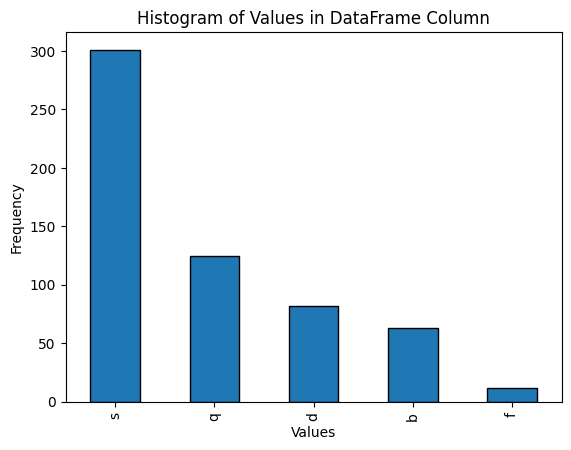

In [8]:
import matplotlib.pyplot as plt




# Get value counts
value_counts = results['preds'].value_counts()

# Plot bar chart
value_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values in DataFrame Column')
plt.show()


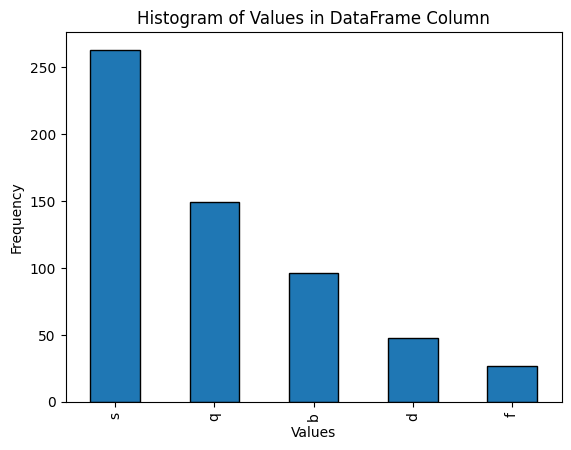

In [9]:
# Get value counts
value_counts = labels.value_counts()

# Plot bar chart
value_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values in DataFrame Column')
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Example DataFrames with true labels and model predictions
true_labels = labels
model_predictions = results['preds']

# Ensure that both DataFrames have the same length and index
assert len(true_labels) == len(model_predictions), "Lengths of true_labels and model_predictions should be the same."
assert true_labels.index.equals(model_predictions.index), "Indices of true_labels and model_predictions should be the same."

# Convert string labels to numerical labels if needed (depends on the specific metrics you want to compute)
# For example, if using precision, recall, and F1-score, numerical labels are required
label_mapping = {label: idx for idx, label in enumerate(true_labels.unique())}
true_labels_numeric = true_labels.map(label_mapping)
model_predictions_numeric = model_predictions.map(label_mapping)

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, model_predictions)
precision = precision_score(true_labels_numeric, model_predictions_numeric, average='weighted')
recall = recall_score(true_labels_numeric, model_predictions_numeric, average='weighted')
f1 = f1_score(true_labels_numeric, model_predictions_numeric, average='weighted')

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, model_predictions))

# Compute and display confusion matrix with columns
conf_matrix = confusion_matrix(true_labels, model_predictions, labels=true_labels.unique())
conf_matrix_df = pd.DataFrame(conf_matrix, index=true_labels.unique(), columns=true_labels.unique())
print("\nConfusion Matrix:")
print(conf_matrix_df)

# Calculate accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracies_df = pd.DataFrame({'Accuracy': class_accuracies}, index=true_labels.unique())
print("\nAccuracy for Each Class:")
print(class_accuracies_df)

Accuracy: 0.6364
Precision: 0.6473
Recall: 0.6364
F1-score: 0.6327

Classification Report:
              precision    recall  f1-score   support

           b       0.57      0.38      0.45        96
           d       0.30      0.52      0.38        48
           f       0.08      0.04      0.05        27
           q       0.90      0.75      0.82       149
           s       0.65      0.75      0.70       263

    accuracy                           0.64       583
   macro avg       0.50      0.49      0.48       583
weighted avg       0.65      0.64      0.63       583


Confusion Matrix:
     s   d    q   b  f
s  197  40    6  15  5
d   19  25    2   2  0
q   23   7  112   2  5
b   47   7    5  36  1
f   15   3    0   8  1

Accuracy for Each Class:
   Accuracy
s  0.749049
d  0.520833
q  0.751678
b  0.375000
f  0.037037


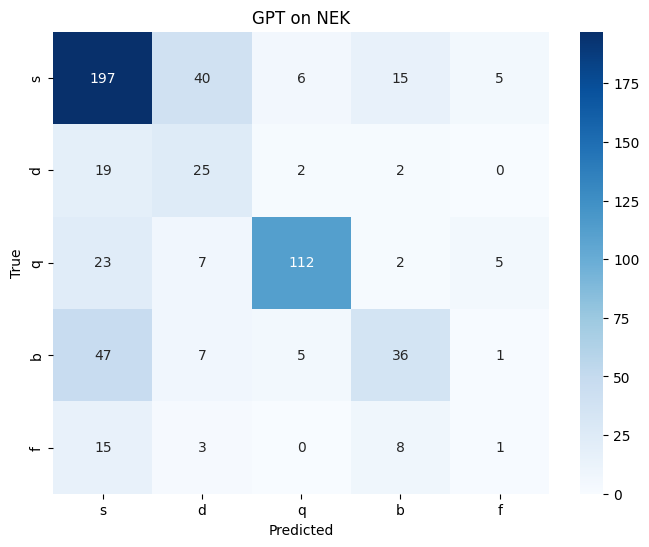

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns






# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=true_labels.unique(), yticklabels=true_labels.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GPT on NEK')
plt.show()

In [35]:
results['true'] = labels
results['utterance'] = content
results.reset_index(drop=True, inplace=True)
results.to_csv('results_and_trans16.csv')